In [86]:
import pandas as pd
import numpy as np
import xlrd
import plotly
import os 
import datetime
import matplotlib.pyplot as plt
from datetime import date, timedelta
from itertools import islice
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from fcmeans import FCM
from sklearn import metrics
from sklearn.model_selection import train_test_split

pd.set_option('max_columns', 200)
pd.set_option('max_colwidth',200)
pd.set_option('max_rows',200)
pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [27]:
data = pd.DataFrame()

for info in os.listdir('E:\Workspace\\登陆异常检测_test'): 
    if info.endswith('.csv'):
        domain = os.path.abspath(r'E:\Workspace\\登陆异常检测_test')
        info = os.path.join(domain,info)
        data_new = pd.read_csv(info)
        data = pd.concat([data, data_new], axis = 0)

In [31]:
print(data.shape[0])
print(data.drop_duplicates().shape[0])

100000
100000


In [48]:
print('logout fail times: {};\nclick app fail times: {}'\
    .format(data.cnt_logout_fail.unique(), data.cnt_app_fail.unique()))

logout fail times: [0];
click app fail times: [0]


In [36]:
user_name_lst = data.login_name.unique().tolist()
data = data[data.login_name.isin(user_name_lst[50:52])]

In [37]:
data.shape

(195, 14)

In [38]:
data_new = pd.DataFrame()
df_new = pd.DataFrame()

################ Data Preparearion: Vectorization & Generating Sliding Window sequences:

for i in user_name_lst[50:52]:

    #### 1. vectorization & fill up the missing nodes within the time range:
    data_i = data[data.login_name == i]
    data_i.set_index('time_node', inplace = True)
    start_date = data_i.index.min()
    end_date = data_i.index.max()    
    # start_date = (datetime.datetime.now() - timedelta(180)).strftime("%Y-%m-%d")
    # end_date = datetime.datetime.now().strftime("%Y-%m-%d")
    time_range = pd.date_range(start_date, end_date, freq = '6H')
    date_list = [datetime.datetime.strftime(x, '%Y-%m-%d %H:%M:%S') for x in time_range]
    data_i = data_i.reindex(date_list).fillna(0)
    data_i.login_name = i
    data_new = pd.concat([data_new, data_i], axis = 0)

    #### 2. setup the sliding windows: window size & moving steps
    sliding_windows_lst = []
    def sliding_window(elements, window_size, moving_step):
        # number of windows
        if len(elements) == window_size:
            return elements
        for i in range(round((len(elements) - window_size)/moving_step + 1)):
            sliding_windows_lst.append(elements[moving_step * i: moving_step * i + window_size])
    lst = data_i.index.tolist()
    sliding_window(lst, 4, 1)  ## setup moving step = 1 & window size = 4

    #### 3. generate sequences: based on the sliding window setup
    k = 1
    df = pd.DataFrame()
    for i in sliding_windows_lst:
        df_k = data_i.loc[i, :].groupby(['login_name']).sum()
        df_k['window_sequence'] = k
        df = pd.concat([df, df_k], axis = 0)
        k = k + 1
    df_new = pd.concat([df_new, df], axis =0)

In [39]:
df_new_ml = df_new[[
    # 'cnt_ip',
    'cnt_login_success', 
    'cnt_login_fail', 
    'cnt_logout_success', 
    'cnt_logout_fail', 
    'cnt_pwd_reset_success', 
    'cnt_pwd_reset_fail',
    'cnt_setup_success', 
    'cnt_setup_fail', 
    'cnt_app_success', 
    'cnt_app_fail', 
    # 'cnt_app',
    'window_sequence'
    ]].reset_index()

##### number of sequences:
usernames = list(df_new_ml.login_name.unique())
for i in usernames:
    print('username: {}, number of sequences: {}'.format(i, df_new_ml[df_new_ml.login_name == i].window_sequence.max()))

username: aijing-004, number of sequences: 714
username: aijing-005, number of sequences: 37


In [40]:
df_new_ml[df_new_ml.login_name == 'aijing-004'].head(2)

,login_name,cnt_login_success,cnt_login_fail,cnt_logout_success,cnt_logout_fail,cnt_pwd_reset_success,cnt_pwd_reset_fail,cnt_setup_success,cnt_setup_fail,cnt_app_success,cnt_app_fail,window_sequence
0,aijing-004,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
1,aijing-004,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,2


In [71]:
data.cnt_setup_fail.unique()

array([0], dtype=int64)

In [92]:
##### weighting the feature / feature normalization

""""""""" TBD """""""""
## Scale the data:
scaler = StandardScaler()

X = df_new_ml[df_new_ml.login_name == 'aijing-004'][[
    'cnt_login_success', 
    'cnt_login_fail', 
    # 'cnt_logout_success', 
    # 'cnt_logout_fail', 
    'cnt_pwd_reset_success', 
    'cnt_pwd_reset_fail',
    'cnt_setup_success', 
    'cnt_setup_fail', 
    'cnt_app_success', 
    # 'cnt_app_fail'
    ]]

X_std = scaler.fit_transform(X)
pd.DataFrame(X_std, columns = X.columns).head()


## Wieghting the features



,cnt_login_success,cnt_login_fail,cnt_pwd_reset_success,cnt_pwd_reset_fail,cnt_setup_success,cnt_setup_fail,cnt_app_success
0,0.17,1.37,-0.08,0.00,0.00,0.00,-0.40
1,0.17,1.37,-0.08,0.00,0.00,0.00,-0.40
2,0.71,-0.28,-0.08,0.00,0.00,0.00,-0.02
3,0.71,-0.28,-0.08,0.00,0.00,0.00,-0.02
4,0.71,-0.28,-0.08,0.00,0.00,0.00,-0.02


In [96]:
print(X.cnt_pwd_reset_fail.unique(), X.cnt_setup_fail.unique(), X.cnt_setup_success.unique())

[0.] [0.] [0.]


In [104]:
#### Feature Importance

""""""""" TBD  """""""""
# PCA
pca = PCA()

X_new = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)



[0.54199583 0.33393738 0.09437429 0.02969249 0.         0.
 0.        ]


In [99]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
np.random.seed(0)

# 10 samples with 5 features
train_features = np.random.rand(10,5)

model = PCA(n_components=2).fit(train_features)
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['a','b','c','d','e']
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

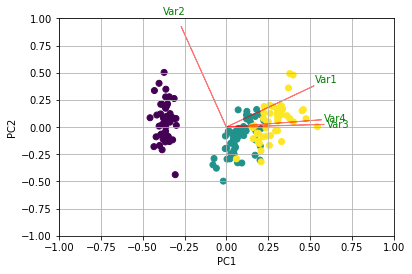

In [97]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [76]:
###### Clustering: DBSCAN

#### setup the radias and minimum sample size grid
eps = list(np.linspace(0.1, 3, 59))
min_samples = list(range(1, 11))

#### DBSCAN clustering
clustering = DBSCAN(eps = 1, min_samples = 6).fit(X_std)
labels = list(clustering.labels_)
n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = labels.count(-1)

### clustering validation measure
metric = metrics.silhouette_score(X_std, labels)            ## silhouette index
metric_2 = metrics.calinski_harabasz_score(X_std,labels)       ## calinski harabasz index
metric_3 = metrics.davies_bouldin_score(X_std,labels)       ## Davies-Bouldin index

### print the result
print('Labels: {};\nNumber of clusters: {};\nNumber of noise: {};\nSilhouette Index: {};\nCalinski Harabasz Index: {};\nDavies-Bouldin index: {}\n'\
    .format(set(labels), n_cluster, n_noise, metric, metric_2, metric_3))

print(pd.Series(labels).value_counts())

clustering.get_params()


# for i in eps:
#     for j in min_samples:
#         clustering = DBSCAN(eps = i, min_samples = j).fit(X)
#         labels = list(clustering.labels_)
#         n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
#         n_noise = labels.count(-1)

#         if n_cluster > 0 and n_cluster < len(labels) - 2:
#             metric = metrics.silhouette_score(X, labels)
#             metric_2 = metrics.calinski_harabasz_score(X,labels)


Labels: {0, 1, 2, -1};
Number of clusters: 3;
Number of noise: 12;
Silhouette Index: 0.5737133113520406;
Calinski Harabasz Index: 185.1691685561688;
Davies-Bouldin index: 1.424161834737778

 1    632
 0     54
 2     16
-1     12
dtype: int64


{'algorithm': 'auto',
 'eps': 1,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 6,
 'n_jobs': None,
 'p': None}

In [77]:
X['label'] = labels
X[X.label == -1]

,cnt_login_fail,cnt_pwd_reset_success,cnt_pwd_reset_fail,cnt_setup_success,cnt_setup_fail,cnt_app_success,label
10,3.00,0.00,0.00,0.00,0.00,5.00,-1
11,3.00,0.00,0.00,0.00,0.00,10.00,-1
12,3.00,0.00,0.00,0.00,0.00,10.00,-1
350,1.00,0.00,0.00,0.00,0.00,13.00,-1
351,1.00,0.00,0.00,0.00,0.00,13.00,-1
352,1.00,0.00,0.00,0.00,0.00,13.00,-1
665,1.00,1.00,0.00,0.00,0.00,3.00,-1
666,6.00,1.00,0.00,0.00,0.00,4.00,-1
667,6.00,1.00,0.00,0.00,0.00,3.00,-1
668,6.00,1.00,0.00,0.00,0.00,3.00,-1


In [23]:
X[X.cnt_login_fail == 2].shape

(16, 6)

In [87]:
#### Clustering: Agglomerative Hierarchical Clustering

# AHC = AgglomerativeClustering(
#         linkage="average", affinity="cityblock",
#         n_clusters=params['n_clusters'], connectivity=connectivity)

Z = linkage(X, method='ward', metric = 'euclidean', optimal_ordering = False)      ## Ward variance minimization algorithm, metric check out scipy.spatial.distance.pdist






array([[  0.,   1.,   0.,   2.],
       [  9., 714.,   0.,   3.],
       [  2.,   3.,   0.,   2.],
       [  4., 716.,   0.,   3.],
       [  5., 717.,   0.,   4.],
       [  6., 718.,   0.,   5.],
       [  7., 719.,   0.,   6.],
       [  8., 720.,   0.,   7.],
       [ 14., 721.,   0.,   8.],
       [ 25., 715.,   0.,   4.]])

In [1]:
fig = plt.figure(figsize = (15,6))
dendrogram(Z, truncate_mode='lastp', p=40)
plt.grid(ls = '--', axis = 'y')
plt.show()

NameError: name 'plt' is not defined

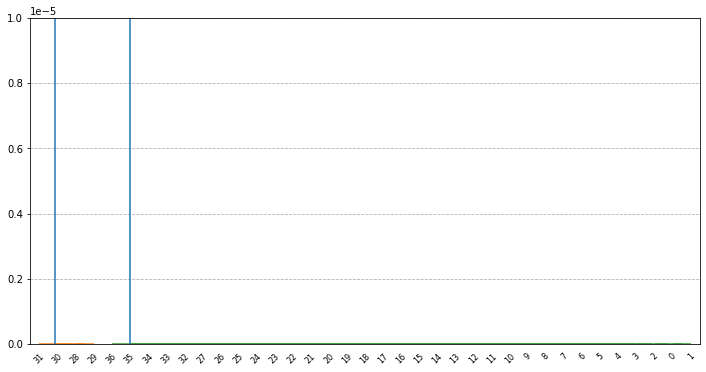

In [57]:
fig = plt.figure(figsize = (12,6))
dendrogram(Z)
plt.grid(ls = '--', axis = 'y')
plt.ylim(0, 1e-5)
plt.show()

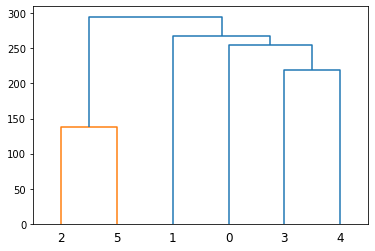

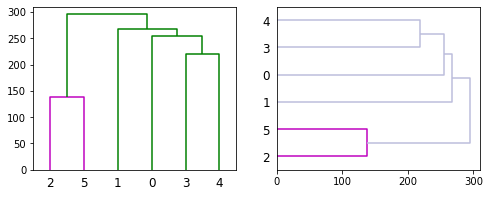

In [80]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(ytdist, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='g',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                           above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [81]:
Z

array([[  2.,   5., 138.,   2.],
       [  3.,   4., 219.,   2.],
       [  0.,   7., 255.,   3.],
       [  1.,   8., 268.,   4.],
       [  6.,   9., 295.,   6.]])

In [14]:
#### Fuzzy C means Clustering










Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


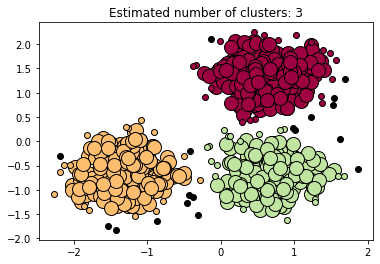

In [64]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [128]:
# sliding_windows_lst = []

# def sliding_window(elements, window_size, moving_step):
#     # number of windows
#     if len(elements) == window_size:
#         return elements
#     for i in range(round((len(elements) - window_size)/moving_step + 1)):
#         sliding_windows_lst.append(elements[moving_step * i: moving_step * i + window_size])

# sliding_window(lst, 4, 1)

In [144]:
# df_new = pd.DataFrame()
# k = 1

# for i in sliding_windows_lst:
#     df_k = df.loc[i, :].groupby(['login_name']).sum()
#     df_k['WIN_LABEL'] = k
#     df_new = pd.concat([df_new, df_k], axis = 0)
#     k = k + 1